In [6]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os
fontsize = 16


sns.set_context("paper", rc={
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": fontsize,
    'ytick.labelsize': fontsize,
    'grid.linewidth': 1.5,
})
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plt.rc('font', family='Times New Roman', weight='bold', size=fontsize)
# plt.rc('lines', lw=3.5)
plt.rcParams.update(
    {'font.size': fontsize, "axes.grid": True, 'grid.linestyle': '-.'})


path_mac = "/Users/jairwu/resources/FaaS/batching-request/test/asplos/dispatch_interval_sensitivity/results/io"
path_linux = "."
PATH = utils.get_data_path(path_mac=path_mac, path_linux=path_linux)
PLOT_DIR = '../plots'
os.system(f"mkdir -p {PLOT_DIR}")
FIGSIZE = (4.5, 2.5)
sns.color_palette("Blues")
pal = sns.color_palette("Blues")
display(pal)
mypal = pal.as_hex()[2:]
print(mypal)


[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

['#89bedc', '#539ecd', '#2b7bba', '#0b559f']


### 每一种策略的 执行时间 和 内存用量 受 Dispatch_intervel 的影响

In [7]:

all_csvs = list(
    map(lambda x: f'{x.split(".csv")[0]}', glob.glob(f"{PATH}/utilization*.csv")))
strategies = ['BaseBatching', "Kraken", "SFS",  "n_Batching"]
legends = ['Vanilla', "Kraken", "SFS",  "FaaSBatch"]
strategy_csvs = {
    strategy: list(filter(lambda x: strategy in x, all_csvs)) for strategy in strategies
}

data = pd.DataFrame()
for strategy, csvs in strategy_csvs.items():
    for csv in csvs:
        df = pd.read_csv(f"{csv}.csv")
        dispatch_interval = csv.split("_")[-1]
        df['dispatch_interval'] = dispatch_interval
        if strategy == 'n_Batching':
            df['strategy'] = "FaaSBatch"
        elif strategy == "BaseBatching":
            df['strategy'] = 'Vanilla'
        else:
            df['strategy'] = strategy

        # 将每个策略，每个dispatch_intervals下的数据标准化，因为每个实验都是单独测试的
        df["Mem_Util(0.01*MB)"] -= df["Mem_Util(0.01*MB)"].min()
        df["Mem_Util(0.01*MB)"] = 100 * df["Mem_Util(0.01*MB)"] / 1024
        df["CPU_Util(%)"] -= df["CPU_Util(%)"].min()
        data = pd.concat([df, data])


#####内存使用总量优化评估######

Disaptch interval 为 0.01 时，FaaSBatch 内存使用平均量为 0.9505037006578946 GB
	-相对于 SFS (2.8152573529411766 GB) 优化了：66.23741344055536%
	-相对于 Kraken (1.6674107142857142 GB) 优化了：42.99522652011555%
	-相对于 Vanilla (2.3123191550925926 GB) 优化了：58.893922641927276%

Disaptch interval 为 0.05 时，FaaSBatch 内存使用平均量为 0.6838507401315789 GB
	-相对于 SFS (2.899571572580645 GB) 优化了：76.41545576600666%
	-相对于 Kraken (1.819921875 GB) 优化了：62.42417053580507%
	-相对于 Vanilla (3.4990762246621623 GB) 优化了：80.45624912907964%

Disaptch interval 为 0.1 时，FaaSBatch 内存使用平均量为 0.6449938322368421 GB
	-相对于 SFS (3.6214535361842106 GB) 优化了：82.18964220326716%
	-相对于 Kraken (1.2931229440789473 GB) 优化了：50.12122898366389%
	-相对于 Vanilla (3.679345703125 GB) 优化了：82.46987686726405%

Disaptch interval 为 0.15 时，FaaSBatch 内存使用平均量为 0.6680201480263159 GB
	-相对于 SFS (3.656425280448718 GB) 优化了：81.73023932423045%
	-相对于 Kraken (1.1989746093749998 GB) 优化了：44.2840454832867%
	-相对于 Vanilla (4.025685864825582 GB) 优化了：83.40605376432522%

Disa

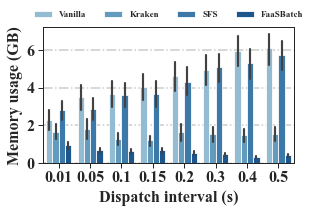

In [8]:

fig, ax1 = plt.subplots(figsize=FIGSIZE)
sns.barplot(x="dispatch_interval", y="Mem_Util(0.01*MB)", hue="strategy", hue_order=legends,
            data=data, palette=mypal, order=sorted(data['dispatch_interval'].unique()))
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-7)
ax1.set_ylabel("Memory usage (GB)", weight='bold')
ax1.set_xlabel("Dispatch interval (s)", weight='bold')

fig.savefig(f"{PLOT_DIR}/usedMemoryAcrossDispatchIntervalsIO.pdf",
            dpi=800, bbox_inches='tight', format='pdf')

strategies = data['strategy'].unique()

# 统计数据
optimized_rates = {strategy: [] for strategy in strategies if strategy != "FaaSBatch"}
print("#####内存使用总量优化评估######")
for interval, df in data.groupby("dispatch_interval"):
    strategies = df['strategy'].unique()
    aux_group = df.groupby("strategy")
    mem_usage_mean = aux_group['Mem_Util(0.01*MB)'].mean()
    print(
        f"\nDisaptch interval 为 {interval} 时，FaaSBatch 内存使用平均量为 {mem_usage_mean['FaaSBatch']} GB")
    for strategy in strategies:
        if "FaaSBatch" in strategy:
            continue
        optimized_rate = (
            mem_usage_mean[strategy] - mem_usage_mean['FaaSBatch']) / mem_usage_mean[strategy]
        optimized_rates[strategy].append(optimized_rate*100)
        print(
            f"\t-相对于 {strategy} ({mem_usage_mean[strategy]} GB) 优化了：{optimized_rate*100}%")

for strategy, optimized_rate_list in optimized_rates.items():
    print(f"FaaSBatch相对于 {strategy} 策略的优化范围为 {min(optimized_rate_list)}\% to {max(optimized_rate_list)}\%")


#####CPU使用总量评估######
FaaSBatch相对于 SFS 策略的优化范围为 78.4534694375737\% to 90.63561894533497\%
FaaSBatch相对于 Kraken 策略的优化范围为 82.18969172037505\% to 90.31896408908958\%
FaaSBatch相对于 Vanilla 策略的优化范围为 81.42668059405567\% to 90.09217764756671\%


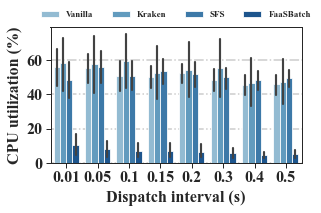

In [9]:
fig, ax1 = plt.subplots(figsize=FIGSIZE)
sns.barplot(x="dispatch_interval", y="CPU_Util(%)", hue="strategy", hue_order=legends,
            data=data, palette=mypal, order=sorted(data['dispatch_interval'].unique()))
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-7)
ax1.set_ylabel("CPU utilization (%)", weight='bold')
ax1.set_xlabel("Dispatch interval (s)", weight='bold')
fig.savefig(f"{PLOT_DIR}/avgCPUUtilsAcrossDispatchIntervalsIO.pdf",
            dpi=800, bbox_inches='tight', format='pdf')

print("#####CPU使用总量评估######")
# 统计数据
optimized_rates = {strategy: [] for strategy in strategies if strategy != "FaaSBatch"}

for interval, df in data.groupby("dispatch_interval"):
    strategies = df['strategy'].unique()
    aux_group = df.groupby("strategy")
    mem_usage_mean = aux_group['CPU_Util(%)'].mean()
    # print(f"\nDisaptch interval 为 {interval} 时:")
    for strategy in strategies:
        if "FaaSBatch" in strategy:
            continue
        optimized_rate = (mem_usage_mean[strategy] - mem_usage_mean['FaaSBatch']) / mem_usage_mean[strategy]
        optimized_rates[strategy].append(optimized_rate*100)
        # print(f"FaaSBatch 相对于 {strategy} 优化了：{optimized_rate*100}%", end=', ')
    # print("")

for strategy, optimized_rate_list in optimized_rates.items():
    print(f"FaaSBatch相对于 {strategy} 策略的优化范围为 {min(optimized_rate_list)}\% to {max(optimized_rate_list)}\%")
